## Notebook for Plant Hatching and Assignment

What to expect:

1. Plant Type Allocation (First half of the spatial-placement pipeline that is imported)
2. Plant Hatching and Assignment Class (Randomly Assign Tree, Create Hatching, Assign Shrubs)

### Plant Type Allocation (Imported from plant_type_allocation.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
from perlin_noise import PerlinNoise

import cv2
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label, center_of_mass

import gymnasium as gym
from gymnasium import spaces

In [2]:
class proceduralGeneratedEnv():
    def __init__(self, octave:float, seed:int, grid_size:tuple, minimum_distance:int, padded_boundary:int):
        """
        Class to randomly generate an environment using perlin noise and dithering

        Args:
            octave (float): octave value from range [1-2] for perlin noise
            seed (int, optional): environment seed to recreate the same environment. Defaults to None.
            grid_size (tuple, optional): (w,h) of environment grid. Defaults to (100,100).
            minimum_distance (int): minimum distance between 2 planting coordinate
            padded_boundary (int): padded distance around the corners that will have no planting coordinate
        """
        self.octave = octave
        self.seed = seed
        self.grid_size = grid_size
        self.minimum_distance = minimum_distance
        self.padded_boundary = padded_boundary

    def create_environment(self):
        """
        Function to create an environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable (if random seed)
        Filters to ensure self.min_distance grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting area (entire environment)
            planting_grid (np.ndarray): self.grid_size grid of 0 for background and 1 for plantable coordinates (just the spot)
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array of all planting coordinates in (y,x) 
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= self.seed if self.seed is not None else random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Retrieve all planting positions
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            
            # Non pre-set seed, check to ensure 7.5% must be plantable, else ignore
            if self.seed != None or len(planting_positions) / len(dithered_perlin_env.flatten()) > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_boundary(perlin_env)
        planting_grid, planting_coords  = self._filter_planting_coords(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords
    
    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    
    def _extract_boundary(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the boundary of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting area (entire environment)
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        # For dilating, expanding the points so that they form a nice boundary blob
        kernel = np.ones((3,3), np.uint8) 
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    
    def _filter_planting_coords(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least self.minimum_distance apart
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is True
        # numpy mask
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False

        # Apply mask to remove coordinates that are too close
        final_planting_coordinates = filtered_planting_positions[keep_array]
        
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        
        return final_grid, final_planting_coordinates    

In [3]:
class plantTypeAllocationEnv(gym.Env):
    def __init__(self, octave:float, theme:int, seed:int=None, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            theme (int): either 0 or 1, 0 for road while 1 for walkway
            seed (int, optional): environment seed to recreate the same environment. Defaults to None.
            grid_size (tuple, optional): (w,h) of environment grid. Defaults to (100,100).
        """
        super(plantTypeAllocationEnv, self).__init__()

        # Step for environment termination
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5

        # Grid variables
        self.theme = theme
        self.seed = seed
        self.grid_size = grid_size

        # Create environment grid
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.env = proceduralGeneratedEnv(octave, seed, grid_size, self.minimum_distance, self.padded_boundary)
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self.env.create_environment()

        # Class Data
        # In y,x coordinates, need to be modified
        self.coordinates = {
            "Tree": [],
            "Shrubs" : []
        }
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Generate embedded coordinates & result grid
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.embeded_planting_coords = self._embed_coordinates()

        # Observation and Action Space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])

    def _embed_coordinates(self):
        """
        Function to convert planting coordinates into their respective embedding
        [xCoord, yCoord, coordDistance, nearCurve, remainingPlantableTrees, originalTreeScore, finalTreeScore, shrubScore, naScore]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1,-1,-1,-1)

        Returns:
            embed_planting_list (np.ndarray): Numpy array of all embeded planting cordinates and padded coordinates 
        """
        # Padded
        embed_planting_list = np.full(((self.maximum_planting_spots), 9), -1, dtype=np.float32)  # Initialize with (-1, -1, ...)
        curve_data = []

        # Get the distance from the boundary, used to measure if near curves
        distance_from_boundary_grid = distance_transform_edt(self.filled_boundary)

        if self.theme == 0:
            # Road
            grid_distance  = self._distance_from_centre()
        else:
            # Walkway
            grid_distance =  distance_from_boundary_grid

        # Minimum distance before can plant tree
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(self.planting_coordinates): #planting coords is (y,x)
            # Retrieve the coordinate distance & the contour line it lies on
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            # Retrieve the coordinate distance & contour line from the boundary
            if self.theme == 0:
                border_contour, border_dist = self._get_contour(distance_from_boundary_grid, planting_coords[1], planting_coords[0])
            else:
                border_contour, border_dist = contour, coord_dist
            curve_data.append([border_contour, border_dist])
            # Retrieve all remaining plantable trees after planting for this coordinate
            remaining_plantable_trees = self._get_remaining_plantable_tree_count(planting_coords[1], planting_coords[0])

            # Calculating the tree, shrub and NA scores
            tree_score = 2 if coord_dist >= min_tree_distance else -1 # Unplantable
            shrub_score = 2 
            na_score = 1 
            if self.theme == 0:
                # Road, shrub should be near center and not near boundary
                if border_contour <= 1:
                    shrub_score = 0
                    na_score = 3
                elif coord_dist <= min_tree_distance:
                    shrub_score = 3
            else:
                # Walkway, shrub is closer to boundary
                if border_contour <= 2:
                    shrub_score = 3
                    na_score = 0 

            # Update embeddings
            embed_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), border_dist, remaining_plantable_trees, tree_score, tree_score, shrub_score, na_score)

        # Calculate near curve (the idea behind it is if they are in the same contour line and distance, )
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        # Update near Curve
        embed_planting_list[:len(self.planting_coordinates), 3] = np.where(is_duplicate, 0, 1)
        
        # Update tree score, if near curve and tree score becomes 2 -> 3
        embed_planting_list[(embed_planting_list[:, 3] == 1) & (embed_planting_list[:, 5] == 2), 5] = 3
        # Sum the tree plantable & maximum plantable trees together
        embed_planting_list[:, 6] = np.where(
            embed_planting_list[:, 6] != -1,  # Condition: 6th index is not -
            embed_planting_list[:, 4] + embed_planting_list[:, 5],  # Valid log operation
            embed_planting_list[:, 6]  # Remains unchanged if 6th index is -1
        )
        
        self.result_grid = embed_planting_list[:, 6:]

        return embed_planting_list.astype(np.int64)

    def _distance_from_centre(self):
        """
        Function to create a numpy grid with each grid being the distance from the centre of planting grid

        Returns:
            distance_from_center (np.ndarray): Array with the distance from centre
        """
        # Retrieve the labels and number of features (either 0 or 1)
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component with elucidean distance
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        return distance_from_center

    def _get_contour(self, grid_distance:np.ndarray, xcoord:int, ycoord:int):
        """
        Function to retrieve the distance of a coordinate from the grid distance and the contour it belongs to

        Args:
            grid_distance (np.ndarray): numpy array with each coordinate showing the distance
            xcoord (int): x coordinate
            ycoord (int): y coordinate

        Returns:
            chosen_contour (int): contour coordinate belongs to
            coordinate_distance (float): distance of coordinate based off grid_distance
        """
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        return chosen_contour, coordinate_distance

    def _get_remaining_plantable_tree_count(self, xcoord:int, ycoord:int):
        """
        Function to retrieve the log number of remaining plantable trees that are self.tree_distance away from coordinate

        Args:
            xcoord (int):  x coordinate
            ycoord (int): y coordinate
        """
        # Get all current tree coordinates
        new_tree_coordinates = np.array(self.coordinates['Tree'] + [[ycoord, xcoord]])
        # Calculate the distance of all planting coordinates from existing tree coordinates
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        # Return all counts where the min_distance > self.tree_distances
        return np.log(np.sum(min_distances >= 50)) if np.sum(min_distances >= self.tree_distance) > 0 else 0
        
    # RL model environment setup
    def _get_observation(self):
        return self.result_grid
    
    def reset(self, seed=None, options=None):
        """
        Reset environment
        """
        self.current_step = 0
        self.coordinates = {
                    "Tree": [],
                    "Shrubs" : []
                }        
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self.env.create_environment()
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.embeded_planting_coords = self._embed_coordinates()
        return self._get_observation() , {}
    
    def step(self, action):

        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.embeded_planting_coords[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:
            # Update coordinate values
            if class_value == 0:
                self.coordinates['Tree'].append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()   

            elif class_value == 1:
                self.coordinates['Shrubs'].append((chosen_value[1], chosen_value[0]))

            # Update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        done = bool(np.all(np.isin(self.result_grid[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    
    def _update_tree_distance(self):
        """
        Function to update which coordinates are now no longer plantable after planting a new tree coordinate
        """
        tree_coordinates = np.array(self.coordinates['Tree'])
        # Get distance from all planting coordinates to all tree coordinates
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < self.tree_distance:
                # No longer plantable
                # Update embedded_coordinates and result grid
                self.embeded_planting_coords[index][-4] = -1
                self.result_grid[index][0] = -1

        # Recalculate all new possible maximum tree planted after the tree coordinate update
        for index, result_row in enumerate(self.result_grid):
            if result_row[0] != -1:
                remaining_plantable_trees = self._get_remaining_plantable_tree_count(self.embeded_planting_coords[index][0], self.embeded_planting_coords[index][1])
                result_row[0] = remaining_plantable_trees + self.embeded_planting_coords[index][5] # Original Tree Score + new log(Max trees)
    
    def _update_density_reward(self):
        """
        Function to calculate the density reward
        """
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        # Shrub, NA ratio
        density_ratios = [0.65, 0.35]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.embeded_planting_coords[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
    
    def retrieve_results(self):
        """
        Function that returns the coordinates and numpy grid of the map.
        Map index:
        {
        0: surrounding
        1: planting areas
        2: trees
        3: shrub 
        }

        Returns:
            theme (int): 0 for road, 1 for walkway
            grid (np.ndarray): numpy array of the updated grid with planted coordinates.
            coordinates (dict): dictionary of {Tree: [], Shrubs:[]} with all the coordinates.
        """
        
        # Swap the (y, x) to (x, y) coordinates only for the output (not the grid mapping)
        updated_coordinates = {
            key: [(x, y) for y, x in value] if key == "Shrubs" else value  # Flip only Shrubs, keep Tree as it is
            for key, value in self.coordinates.items()
        }

        # Use self.filled_boundary as the base grid
        updated_grid = self.filled_boundary.copy()

        # Map the updated coordinates to the grid
        for key, coordinates in self.coordinates.items():  # Use the original `self.coordinates`
            for y, x in coordinates:  # Grid uses (y, x)
                updated_grid[y, x] = 2 if key == 'Tree' else 3  # Assign Tree as 2, Shrub as 3

        return self.theme, updated_grid, updated_coordinates

    
    def render(self, only_plant:bool=False, show_coord:bool=False):
        """
        Function to render the grid

        Args:
            only_plant (bool, optional): Show only planted spots, NA is not shown. Defaults to False.
            show_coord (bool, optional): Show reward values. Defaults to False.
        """
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, d2, d3, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()

In [ ]:
from stable_baselines3 import PPO
model = PPO.load('../src/models/plantTypeAllocationModel.zip')

In [ ]:
def eval_model(model:PPO, eval_env, show_results:bool=True, return_results:bool=True):
    """
    Function to evaluate model onto a defined environment

    Args:
        model (PPO): trained PPO model
        eval_env: environment to evaluate model on
        show_results (bool, optional): Render final grid. Defaults to True.
        return_results (bool, optional): Return the results (call environment.retrieve_results()). Defaults to True.
    """
    obs, info = eval_env.reset()
    total_reward = 0

    for i in range(eval_env.max_step):
        # Get action from the model
        action, _ = model.predict(obs)  # Get the predicted action
        obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
        total_reward += reward  # Accumulate rewards

        if done:
            break

    print(f"Model completed in {i} steps, total reward {total_reward}")
    if show_results:
        eval_env.render(True)
    if return_results:
        return eval_env.retrieve_results()

Model completed in 60 steps, total reward 35.17469988018274


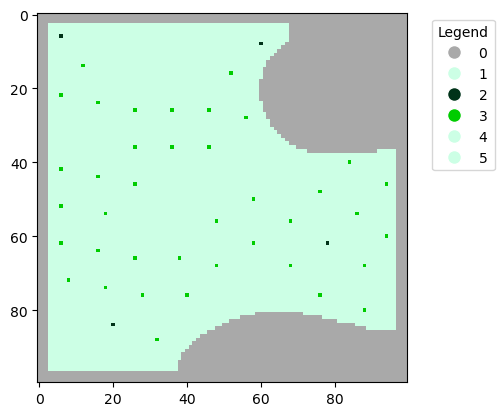

0
{'Tree': [(6, 6), (60, 8), (20, 84), (78, 62)], 'Shrubs': [(46, 36), (26, 46), (26, 66), (68, 68), (48, 68), (8, 72), (88, 80), (76, 76), (40, 76), (32, 88), (58, 62), (94, 60), (28, 76), (16, 44), (16, 64), (86, 54), (88, 68), (68, 56), (18, 54), (46, 26), (6, 22), (18, 74), (94, 46), (26, 26), (58, 50), (52, 16), (84, 40), (48, 56), (6, 62), (16, 24), (76, 48), (56, 28), (26, 36), (36, 26), (6, 52), (38, 66), (6, 42), (12, 14), (36, 36)]}


In [ ]:
eval_env = plantTypeAllocationEnv(1.25, 0, 6)
theme1, grid1, coordinates1 = eval_model(model, eval_env)
print(theme1)
print(coordinates1)

### Plant Hatching and Assignment Class

In [ ]:
import numpy as np
import random
import cv2
import copy
import re
from typing import Union 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.spatial.distance import cdist
from scipy.ndimage import label

In [ ]:
selected_plants = [
        {
            "Scientific Name": "Excoecaria cochinchinensis",
            "Common Name": "Chinese Croton",
            "Species ID": 2010,
            "Link": "https://www.nparks.gov.sg/florafaunaweb/flora/2/0/2010",
            "Plant Type": [
                "Shrub"
            ],
            "Light Preference": [
                "Full Sun",
                "Semi Shade"
            ],
            "Water Preference": [
                "Moderate Water"
            ],
            "Drought Tolerant": False,
            "Native to SG": False,
            "Fruit Bearing": False,
            "Fragrant Plant": False,
            "Maximum Height (m)": 1.0,
            "Flower Colour": "Green",
            "Hazard": "Toxic Upon Ingestion, Irritant - Sap",
            "Attracted Animals": "-",
            "Native habitat": "Terrestrial",
            "Mature Leaf Colour": "Green, Purple",
            "Young Flush Leaf Colour": "Red",
            "Leaf Area Index": "4.5 (Shrub & Groundcover - Dicot)",
            "Growth Rate": [
                "-"
            ],
            "Trunk Texture": "N/A",
            "Trunk Colour": "N/A",
            "Leaf Texture": [
                "Medium"
            ],
            "Canopy Radius": "N/A"
        },
        {
            "Scientific Name": "Arrhenatherum elatius subsp. bulbosum 'Variegatum'",
            "Common Name": "Striped Tuber Oat Grass",
            "Species ID": 3427,
            "Link": "https://www.nparks.gov.sg/florafaunaweb/flora/3/4/3427",
            "Plant Type": [
                "Grass or Grass-like Plant",
                "Shrub"
            ],
            "Light Preference": [
                "Full Sun",
                "Semi Shade"
            ],
            "Water Preference": [
                "Moderate Water"
            ],
            "Drought Tolerant": False,
            "Native to SG": False,
            "Fruit Bearing": False,
            "Fragrant Plant": False,
            "Maximum Height (m)": 0.5,
            "Flower Colour": "Cream / Off-White, Green, Purple",
            "Hazard": "N/A",
            "Attracted Animals": "-",
            "Native habitat": "Terrestrial (Grassland / Savannah/ Scrubland)",
            "Mature Leaf Colour": "Cream / Off-White, Green, White",
            "Young Flush Leaf Colour": "N/A",
            "Leaf Area Index": "3.5 (Shrub & Groundcover - Monocot)",
            "Growth Rate": [
                "Slow"
            ],
            "Trunk Texture": "N/A",
            "Trunk Colour": "N/A",
            "Leaf Texture": [
                "Fine"
            ],
            "Canopy Radius": "N/A"
        },
        {
            "Scientific Name": "Aglaonema simplex (Blume) Blume",
            "Common Name": "Malayan Sword",
            "Species ID": 3740,
            "Link": "https://www.nparks.gov.sg/florafaunaweb/flora/3/7/3740",
            "Plant Type": [
                "Herbaceous Plant",
                "Shrub"
            ],
            "Light Preference": [
                "Full Shade",
                "Semi Shade"
            ],
            "Water Preference": [
                "Lots of Water",
                "Moderate Water"
            ],
            "Drought Tolerant": False,
            "Native to SG": True,
            "Fruit Bearing": False,
            "Fragrant Plant": False,
            "Maximum Height (m)": 1.2,
            "Flower Colour": "Cream / Off-White, White",
            "Hazard": "N/A",
            "Attracted Animals": "-",
            "Native habitat": "Terrestrial (Primary Rainforest, Secondary Rainforest, Monsoon Forest, Freshwater Swamp Forest)",
            "Mature Leaf Colour": "Green",
            "Young Flush Leaf Colour": "N/A",
            "Leaf Area Index": "3.5 (Shrub & Groundcover - Monocot)",
            "Growth Rate": [
                "Slow"
            ],
            "Trunk Texture": "N/A",
            "Trunk Colour": "N/A",
            "Leaf Texture": [
                "Coarse"
            ],
            "Canopy Radius": "N/A"
        },
        {
            "Scientific Name": "Acrotrema costatum Jack",
            "Common Name": "Yellow Jungle Star",
            "Species ID": 3739,
            "Link": "https://www.nparks.gov.sg/florafaunaweb/flora/3/7/3739",
            "Plant Type": [
                "Creeper",
                "Herbaceous Plant",
                "Shrub"
            ],
            "Light Preference": [
                "Full Shade",
                "Semi Shade"
            ],
            "Water Preference": [
                "Moderate Water"
            ],
            "Drought Tolerant": False,
            "Native to SG": False,
            "Fruit Bearing": False,
            "Fragrant Plant": False,
            "Maximum Height (m)": 0.3,
            "Flower Colour": "Yellow / Golden",
            "Hazard": "N/A",
            "Attracted Animals": "-",
            "Native habitat": "Terrestrial (Secondary Rainforest, Monsoon Forest)",
            "Mature Leaf Colour": "Green, Silver / Grey",
            "Young Flush Leaf Colour": "N/A",
            "Leaf Area Index": "4.5 (Shrub & Groundcover - Dicot)",
            "Growth Rate": [
                "Moderate"
            ],
            "Trunk Texture": "N/A",
            "Trunk Colour": "N/A",
            "Leaf Texture": [
                "Coarse"
            ],
            "Canopy Radius": "N/A"
        },
        {
            "Scientific Name": "Gardenia tubifera Wall.",
            "Common Name": "Water Gardenia",
            "Species ID": 2933,
            "Link": "https://www.nparks.gov.sg/florafaunaweb/flora/2/9/2933",
            "Plant Type": [
                "Tree"
            ],
            "Light Preference": [
                "Full Sun"
            ],
            "Water Preference": [
                "Lots of Water",
                "Moderate Water"
            ],
            "Drought Tolerant": False,
            "Native to SG": True,
            "Fruit Bearing": False,
            "Fragrant Plant": True,
            "Maximum Height (m)": 12.0,
            "Flower Colour": "Cream / Off-White, Yellow / Golden, Orange",
            "Hazard": "N/A",
            "Attracted Animals": "Bird-Attracting (Fruits), Butterfly-Attracting (Flower Nectar)",
            "Native habitat": "Terrestrial",
            "Mature Leaf Colour": "Green",
            "Young Flush Leaf Colour": "N/A",
            "Leaf Area Index": "3.0 (Tree - Intermediate Canopy)",
            "Growth Rate": [
                "Moderate"
            ],
            "Trunk Texture": "-",
            "Trunk Colour": "-",
            "Leaf Texture": [
                "N/A"
            ],
            "Canopy Radius": 19
        },
        {
            "Scientific Name": "Pometia pinnata J. R. Forst. & G. Forst.",
            "Common Name": "Island Lychee",
            "Species ID": 3084,
            "Link": "https://www.nparks.gov.sg/florafaunaweb/flora/3/0/3084",
            "Plant Type": [
                "Tree"
            ],
            "Light Preference": [
                "Full Sun"
            ],
            "Water Preference": [
                "Lots of Water",
                "Moderate Water"
            ],
            "Drought Tolerant": False,
            "Native to SG": True,
            "Fruit Bearing": True,
            "Fragrant Plant": False,
            "Maximum Height (m)": 50.0,
            "Flower Colour": "Cream / Off-White, Green, Yellow / Golden",
            "Hazard": "N/A",
            "Attracted Animals": "-",
            "Native habitat": "Terrestrial (Primary Rainforest, Secondary Rainforest, Monsoon Forest, Freshwater Swamp Forest, Riverine)",
            "Mature Leaf Colour": "Green",
            "Young Flush Leaf Colour": "Red, Orange",
            "Leaf Area Index": "3.0 (Tree - Intermediate Canopy)",
            "Growth Rate": [
                "Moderate"
            ],
            "Trunk Texture": "-",
            "Trunk Colour": "Reddish Brown",
            "Leaf Texture": [
                "N/A"
            ],
            "Canopy Radius": 20
        }
    ]

theme = "Manicured"


In [ ]:
class plantHatchingAndAssignment():
    def __init__(self, 
                 starting_grid:np.ndarray, 
                 selected_plants_dict: dict, 
                 tree_and_shrub_location_dict: dict,
                 theme: str, 
                 randomised_seed: int = None, 
                 dominance_threshold: float = 0.1, 
                 binary_scale: bool= False):
        """
        Plant assignment class
        After taking in the planting grid and the planting coordinates with their assigned plant types
        1. The class will originally randomly assign trees to the tree coordinates
        2. Based on the tree shade and planting grid, hatching will be done to segment the planting areas
        3. Shrubs will then be assigned into each segmented area based on their attributes

        Args:
            starting_grid (np.ndarray): Grid received from procedural generation, 0 means unplantable, 1 means plantable, 2 means tree, 3 means shrub.
            selected_theme_plant_palette (dict): Input from the UI containing the theme and plant palette.
            tree_and_shrub_location_dict (dict["Tree"/"Shrub"]): Dictionary containing tree and shrub coordinates. 
            randomised_seed (int, optional): Randomised seed, defaults to None.
            dominance_threshold (float, optional): Minimum DIFFERENCE threshold between the heatmap scores of each plant species to determine if they are dominant.
            binary_scale (bool, optional): Boolean to determine if the impact of the distance from point of interest (boundary/centre) is on a gradient or binary scale. Defaults to False for gradient, if True binary scale will be used.
        """
        # Initilisation of variables
        self.randomized_seed = randomised_seed
        self.threshold = dominance_threshold
        self.binary_scale = binary_scale

        # Grid variables
        self.unplantable_int = 0
        self.plantable_int = 1
        self.tree_int = 2
        self.shrub_int = 3

        self.starting_grid = starting_grid
        self.selected_plants_dict = selected_plants_dict
        self.tree_shrub_coordinate_dict = tree_and_shrub_location_dict
        self.theme = theme
        
        # To be initialised during the initialise_info_function
        self.grid_shape = None
        self.tree_info_list = None
        self.shrub_info_list = None
        self.starting_shrub_seed_list = None
        self.tree_radii_dict = None
        self.tree_id_dict = None

        # Random initialisation of tree planting
        self._assign_trees()
        
        # Initialise Shrub mapping
        self.seed_mapping, self.shrub_int_list = self._create_seed_labels() 


    def hatch_allocate_plants(self, visualise=False):      
        """
        Function to allocate trees and shrubs into every coordinate

        Returns:
            output_json (dictionary): Data to be returned to the UI
        """  
        # Generate Hatching
        hatching_grid = self._generate_hatching()

        # Allocate shrubs and remove hatching segments without any coordinates
        final_grid, assigned_seed_dict, grid_seed_mapping = self._allocate_plants(hatching_grid)

        # Format output for backend
        output_json = self._create_json(final_grid, assigned_seed_dict, grid_seed_mapping)

        # Visualise plantingg area is needed
        if visualise:
            self._visualize_grid_with_outlines(final_grid, assigned_seed_dict, grid_seed_mapping, self.tree_radii_dict)
        
        return output_json
    
    ## Initialiser functions
    def _assign_trees(self):
        """
        Function used to initialise grid information and randomly assign trees to tree coordinate
        Randomly assign trees to each tree coordinate

        Returns: 
            starting_grid (np.ndarray): Grid received from procedural generation, 0 means unplantable, 1 means plantable, 2 means tree, 3 means shrub.
            selected_theme_plant_palette (dict): Input from the UI containing the theme and plant palette.
            tree_and_shrub_location_dict (dict["Tree"/"Shrub"]): Dictionary containing tree and shrub coordinates. 
        """ 
        # Retrieve grid information
        self.grid_shape = (self.starting_grid.shape)
        self.starting_shrub_seed_list = self.tree_shrub_coordinate_dict["Shrubs"]
        trees_list = self.tree_shrub_coordinate_dict["Tree"]

        # Retrieve plant palette information
        self.tree_info_list, self.shrub_info_list  = self._retrive_trees_shrubs_from_input_dict()
        
        # Randomly allocate trees and update with information for shade shrubs
        new_trees = self._allocate_trees_to_coordinates(trees_list)
        self.tree_radii_dict = {pos: data[1] for pos, data in new_trees.items()}
        self.tree_id_dict = {pos: data[2] for pos, data in new_trees.items()}    

    def _create_seed_labels(self):
            """
            Categorises shrubs based on their light preferences and border proximity, 
            assigns seed numbers to each shrub, and returns the seed mappings.

            Shrubs are divided into the following categories:
            - BSH: Border, Shade Hating
            - NBSL: Not Border, Shade Loving
            - NBSH: Not Border, Shade Hating
            - BSL: Border, Shade Loving

            Seed numbers are generated uniquely for each category based on conditions, ensuring no overlap.

            Args:
                shrubs_list (list): A list of dictionaries representing shrubs. Each dictionary contains:
                    - "Plant Type" (str): Type of the plant (e.g., "Shrub").
                    - "Light Preference" (str): Light preference (e.g., "Full Shade", "Semi Shade").
                    - "Hazard" (str): Whether the shrub is on the border ("-" indicates it's on the border).
                    - "Scientific Name" (str): Name of the shrub species.

            Returns:
                - seed_mapping (list of dict): A list of dictionaries where each dictionary represents a shrub with:
                    - "Seed Number" (int): The assigned seed number.
                    - "Shrub Name" (str): The Scientific Name of the shrub.
                - seeds_list (list of int): A list of all seed numbers assigned to shrubs.
            """
            BSH = 0  # Border, Shade Hating
            NBSL = 0  # Not Border, Shade Loving
            NBSH = 0  # Not Border, Shade Hating
            BSL = 0  # Border, Shade Loving
            shrub_mapping = {  # To map seeds to shrub names
                "BSH": [],
                "NBSL": [],
                "NBSH": [],
                "BSL": []
            }

            # Process each shrub and categorize
            for shrub in self.shrub_info_list:
                if shrub["Hazard"] != "-":  # NB: Not Border (hazard present)
                    if self._contains_semi_shade(shrub["Light Preference"]) or self._contains_full_shade(shrub["Light Preference"]):
                        # NBSL: Not Border, Shade Loving
                        NBSL += 1
                        shrub_mapping["NBSL"].append(shrub["Scientific Name"])
                    else:
                        # NBSH: Not Border, Shade Hating
                        NBSH += 1
                        shrub_mapping["NBSH"].append(shrub["Scientific Name"])
                else:  # B: Border (no hazard)
                    if self._contains_semi_shade(shrub["Light Preference"]) or self._contains_full_shade(shrub["Light Preference"]):
                        # BSL: Border, Shade Loving
                        BSL += 1
                        shrub_mapping["BSL"].append(shrub["Scientific Name"])
                    else:
                        # BSH: Border, Shade Hating
                        BSH += 1
                        shrub_mapping["BSH"].append(shrub["Scientific Name"])

            # Generate seed numbers for the categories
            seedlists = self._assign_hatching_index(startingNumber=3, BSH=BSH, NBSL=NBSL, BSL=BSL, NBSH=NBSH)

            # Map seed numbers to shrubs
            seed_mapping = []
            seeds_list = []
            for category in ["BSH", "NBSL", "NBSH", "BSL"]:
                seeds = seedlists[category]
                names = shrub_mapping[category]
                for seed, name in zip(seeds, names):
                    seed_mapping.append({"Seed Number": seed, "Shrub Name": name})
                    seeds_list.append(seed)

            return seed_mapping, seeds_list

    ## High level functions used in hatch_allocate_plants
    def _generate_hatching(self):
        """
        Generate the raw hatching map before applying cleaning or post-processing steps.

        This function generates a raw heatmap that segments the grid 
        into different regions assigned to different plants based on their influence and logical suitability.

        Returns:
            np.ndarray: The output grid where each region is labeled with a unique integer representing a plant type.
        """
        # Choose starting shrub coordinates for segmentation
        seed_to_int_dict = self._choose_starter_slots() 
        # Randomly generate worley noise map
        noise_map = self._generate_worley_heatmap()
        # Uses the noise map generated and the seed of each species to generate a random heatmap of each species' influence on the grid
        noise_grids = self._combined_noisemap(noise_map, seed_to_int_dict) 
        # Creates a heatmap for each species, combining both the random influence from the noise_grid as well as logical influence based on the suitability of each species for each region of the map
        heatmaps = self._create_heatmaps(noise_grids) 
        # Allocates the grid to each species based on the heatmaps generates above 
        output_grid = self._apply_influence_grids_with_border(heatmaps)
        return output_grid
    
    def _allocate_plants(self, uncleaned_hatch_grid:np.ndarray):
        """
        Allocate plants to regions based on the hatching grid and theme, performing cleaning, adjustments, and optional mirroring.

        This function processes the uncleaned hatching grid to generate a cleaned grid and allocate plants to each region 
        based on plant attributes. It also adjusts seed coordinates for naturalistic placement and removes empty regions.

        Args:
            uncleaned_hatch_grid (np.ndarray): A numpy array representing the raw hatching grid with regions labeled for different plants.

        Returns:
            tuple:
                - cleaned_grid (np.ndarray): A cleaned and adjusted grid with regions labeled by plant types.
                - shifted_seeds_dict (dict): A dictionary where keys are integers representing plant types, 
                  and values are lists of tuples representing seed locations.
                - seed_mapping (dict): A mapping of seed numbers to shrub names.
        """
        # Removes any small imperfections in between regions and creates smooth patches
        cleaned_grid = self._fill_small_regions(uncleaned_hatch_grid)
        # Assign shrubs to each hatching region based off plant attributes
        seed_dict = self._assign_shrubs(cleaned_grid)
        # Jitter coordinates to ensure they are slightly more naturalistic and do not lie on hatching region boundaries
        shifted_seeds_dict = self._jitter_coordinate(cleaned_grid, seed_dict)
        # Remove any hatching regions that do not have any plantable coordinates
        cleaned_grid = self._remove_empty_regions(cleaned_grid, shifted_seeds_dict)

        # For manicured theming, we mirror the hatching to provide a design
        if self.theme.lower() == "manicured":
            cleaned_grid, shifted_seeds_dict, mirrored_trees, mirrored_tree_id_dict, _ = self._mirror_grid(cleaned_grid, shifted_seeds_dict)
            self.tree_radii_dict = mirrored_trees
            self.tree_id_dict = mirrored_tree_id_dict

        seed_mapping = {seed["Seed Number"]: seed["Shrub Name"] for seed in self.seed_mapping}

        return cleaned_grid, shifted_seeds_dict, seed_mapping

    def _create_json(self, output_grid: np.ndarray, output_seed_dict: dict, seed_mapping: list):
        """
        Generate a JSON output by transforming the output grid and coordinates mapped to species IDs.
        
        This function processes the input grid and mapping data to create a structured JSON output. The grid transformation involves:
        - Marking unplantable areas as `0`.
        - Marking plantable areas (not assigned to trees or shrubs) as `1`.
        - Marking tree locations as `2`.
        - Marking shrub locations as `3`.

        It also generates a `coordinates` dictionary that maps the coordinates of shrubs and trees to their respective species IDs, based on provided mappings.

        Args:
            output_grid (np.ndarray): 
                A 2D numpy array where each cell represents:
                - `0`: Unplantable area.
                - Positive integers (e.g., `2`, `3`, `4`): Plantable areas or seed numbers indicating shrub locations.

            output_seed_dict (dict): 
                A dictionary where keys are seed numbers (integers) corresponding to shrub species, 
                and values are lists of tuples representing the coordinates (row, column) where the shrubs are located.

            seed_mapping (list): 
                A list mapping seed numbers (indices) to shrub Scientific Names (strings). 
                This is used to resolve which Scientific Name corresponds to a seed number.

        Returns:
            dict: A JSON-compatible dictionary containing:
                - "grid" (list of lists): A transformed grid where:
                    - `0` represents unplantable areas.
                    - `1` represents plantable areas.
                    - `2` represents tree locations.
                    - `3` represents shrub locations.
                - "coordinates" (dict): A dictionary where:
                    - Keys are string representations of coordinates (e.g., "(row, column)").
                    - Values are species IDs for shrubs and trees.
        """

        # Initialize coordinates dictionary for shrubs and trees
        coordinates = {}

        # Add shrub coordinates and map their species IDs
        for seed_number, positions in output_seed_dict.items():
            for position in positions:
                shrub_data = next(
                    (shrub for shrub in self.shrub_info_list if shrub["Scientific Name"] == seed_mapping[seed_number]),
                    None
                )
                if shrub_data:
                    coordinates[str(position)] = shrub_data.get("Species ID", "Unknown")
                else:
                    coordinates[str(position)] = "Unknown"

        # Add tree coordinates and their species IDs
        for (y, x), species_id in self.tree_id_dict.items():
            coordinates[str((y, x))] = species_id

        # Initialize the final grid with 0 (unplantable areas)
        final_grid = np.zeros_like(output_grid)

        # Mark plantable areas (1): Convert all non-zero, non-tree, and non-shrub values to 1
        plantable_positions = np.argwhere(output_grid > 0)
        for y, x in plantable_positions:
            if (y, x) not in self.tree_id_dict.keys() and str((y, x)) not in coordinates:
                final_grid[y, x] = 1

        # Mark shrubs as 3 based on the coordinates dictionary
        for coord, species_id in coordinates.items():
            y, x = eval(coord)  # Convert string back to tuple
            if isinstance(species_id, int):
                final_grid[y, x] = 3

        # Mark trees as 2 using tree_id_dict
        for (y, x) in self.tree_id_dict.keys():
            final_grid[y, x] = 2

        # Prepare JSON output
        json_output = {
            "grid": final_grid.tolist(),
            "coordinates": coordinates
        }

        return json_output

        
    def _visualize_grid_with_outlines(self, grid:np.ndarray, shrubs_dict:dict, seed_name_mapping:dict, tree_radii:dict):
        """
        Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

        Args:
            grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
            shrubs_dict (dict): Dictionary where keys are types (seed numbers) and values are lists of (y, x) positions.
            seed_name_mapping (dict): Dictionary mapping seed numbers to shrub names.
            tree_radii (dict): Dictionary mapping (y, x) positions to radii.
        """
        # Define a colormap for visualization
        unique_values = np.unique(grid)
        colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors

        # Create a color map dictionary
        color_map = {val: colors[i] for i, val in enumerate(unique_values)}

        # Generate type labels based on seed_name_mapping
        type_labels = {
            val: seed_name_mapping.get(val, "Unplantable Area" if val == 0 else f"Unknown {val}")
            for val in unique_values
        }

        # Create the plot
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

        # Draw the grid points
        for value, color in color_map.items():
            indices = np.argwhere(grid == value)
            plt.scatter(
                indices[:, 1],
                indices[:, 0],
                color=color,
                label=type_labels.get(value, f"Unknown {value}"),
                s=50,
                alpha=0.8
            )

        # Draw the outlines for shrubs
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                # Draw only the outline of the circle with a smaller radius
                circle = mpatches.Circle(
                    (x, y),
                    radius=1.0,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1.5,
                    zorder=5
                )
                ax.add_patch(circle)

        # Draw the outlines for trees with their radii, clipping to grid boundary
        grid_height, grid_width = grid.shape
        for (y, x), radius in tree_radii.items():
            # Only draw circles within bounds
            if 0 <= x < grid_width and 0 <= y < grid_height:
                circle = mpatches.Circle(
                    (x, y),
                    radius=radius,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    zorder=5,
                    clip_on=True  # Clip circles to the axes
                )
                ax.add_patch(circle)

        # Set axis limits to grid size to enforce clipping
        ax.set_xlim(-0.5, grid.shape[1] - 0.5)
        ax.set_ylim(-0.5, grid.shape[0] - 0.5)

        # Invert y-axis for correct orientation
        ax.invert_yaxis()

        # Add title and legend
        plt.title("Grid Visualization with Shrub Outlines")
        plt.legend(title="Legend (Shrub Names)", loc='upper right')
        plt.grid(False)
        plt.show()
    
    ## Component Functions

    def _retrive_trees_shrubs_from_input_dict(self):
        """
        Retrieve and separate plants from the input dictionary into trees and shrubs.

        This method parses the `selected_plants_dict` attribute and categorizes plants into trees or shrubs 
        based on their "Plant Type". Plants identified as trees or shrubs are appended to separate lists 
        for further processing.

        Returns:
            tuple:
                - Tree_Species (list of dict): A list containing dictionaries of plants categorized as trees.
                - Shrub_Species (list of dict): A list containing dictionaries of plants categorized as shrubs.

        Notes:
            - The categorization is determined by matching the "Plant Type" against predefined checks for "Tree", 
              "Shrub", or "Palm" using helper methods `_contains_tree`, `_contains_shrub`, and `_contains_palm`.
            - If a plant's type does not match any known category, it is ignored, and a debug message is printed.

        Raises:
            ValueError: If the `selected_plants_dict` attribute is not defined or improperly formatted.
        """
        Tree_Species = []
        Shrub_Species = []
        selected_plants_list = self.selected_plants_dict
        for plant in selected_plants_list:
            # It is a tree
            if self._contains_palm(plant["Plant Type"]) or self._contains_tree(plant["Plant Type"]):
                Tree_Species.append(plant)
            # It is a shrub
            elif self._contains_shrub(plant["Plant Type"]):
                Shrub_Species.append(plant)
            else:
                print("WHATT ARE THOSEE")
                continue
        return Tree_Species, Shrub_Species
    
    def _allocate_trees_to_coordinates(self, tree_positions:list):
        """
        Randomly allocate tree species and their radii to specified grid coordinates.

        This method assigns a tree species to each provided coordinate in `tree_positions` by randomly selecting 
        from the available tree data in `self.tree_info_list`. Each assigned tree includes its Scientific Name, 
        canopy radius, and species ID.

        Args:
            tree_positions (list of tuple): A list of (y, x) grid coordinates where trees should be allocated.

        Returns:
            dict: A dictionary where keys are grid coordinates (tuples) and values are lists containing:
                  - Scientific Name (str)
                  - Canopy Radius (float)
                  - Species ID (str or int)

        Raises:
            ValueError: If no tree species are available in `self.tree_info_list`.

        Notes:
            - The method ensures that the canopy radius is converted to a float if available; otherwise, it defaults to 0.
            - Random allocation allows for diverse placement of tree species across the grid.
            - The input `tree_positions` should contain valid (y, x) coordinates that exist within the grid.
        """

        # Check if there are any tree species
        if not self.tree_info_list:
            raise ValueError("No tree species available in the tree list.")

        # Initialize the output dictionary
        allocated_trees = {}

        # Assign each coordinate a tree species and radius
        for pos in tree_positions:
            # Randomly select a tree species
            selected_tree = random.choice(self.tree_info_list)
            name = selected_tree["Scientific Name"]
            radius = selected_tree.get("Canopy Radius", "None")
            id = selected_tree.get("Species ID")
            
            # Ensure radius is a float if possible
            radius = float(radius) if radius != "None" else 0
            
            # Allocate the tree to the coordinate
            allocated_trees[pos] = [name, radius, id]

        return allocated_trees
    
    def _assign_hatching_index(self, BSH:int=0, NBSL:int=0, NBSH:int=0, BSL:int=0, startingNumber:int=3):
        """
        Selects integers for each category based on the specified conditions:
        - BSH: Border, shade hating (not a multiple of 2, multiple of 3)
        - NBSL: Not Border, shade loving (multiple of 2, not a multiple of 3)
        - NBSH: Not Border, shade hating (not a multiple of 2, not a multiple of 3)
        - BSL: Border, shade loving (multiple of 2, multiple of 3)

        Args:
            BSH (int): Number of integers required for Border, shade hating condition.
            NBSL (int): Number of integers required for Not Border, shade loving condition.
            NBSH (int): Number of integers required for Not Border, shade hating condition.
            BSL (int): Number of integers required for Border, shade loving condition.
            startingNumber (int): The number to start iterating from.

        Returns:
            dict: A dictionary with keys 'BSH', 'NBSL', 'NBSH', 'BSL' and lists of integers as values.
        """
        result = {"BSH": [], "NBSL": [], "NBSH": [], "BSL": []}
        current_number = startingNumber

        while len(result["BSH"]) < BSH or len(result["NBSL"]) < NBSL or len(result["NBSH"]) < NBSH or len(result["BSL"]) < BSL:
            if current_number % 2 != 0 and current_number % 3 == 0 and len(result["BSH"]) < BSH:
                result["BSH"].append(current_number)
            elif current_number % 2 == 0 and current_number % 3 != 0 and len(result["NBSL"]) < NBSL:
                result["NBSL"].append(current_number)
            elif current_number % 2 != 0 and current_number % 3 != 0 and len(result["NBSH"]) < NBSH:
                result["NBSH"].append(current_number)
            elif current_number % 2 == 0 and current_number % 3 == 0 and len(result["BSL"]) < BSL:
                result["BSL"].append(current_number)
            
            current_number += 1

        return result

    def _choose_starter_slots(self, percentage_of_starters:float=0.8):
        """
        Selects a percentage of shrub positions to be assigned as starter slots and groups them by starter types.

        This method selects a subset of shrub positions from the `starting_shrub_seed_list` and assigns them 
        starter types based on the `seed_mapping`. The proportion of shrubs to be assigned as starters is 
        determined by the `percentage_of_starters` argument.

        Args:
            percentage_of_starters (float): The fraction of shrub positions to allocate as starter slots. 
                                            Defaults to 0.8 (80%).

        Returns:
            dict: A dictionary where keys are seed numbers (starter types) from the `seed_mapping` and values 
                  are lists of assigned shrub coordinates.

        Notes:
            - Ensures that at least one shrub is selected as a starter, even if the calculated percentage is less than 1.
            - The assignment of starter types cycles through the `seed_mapping` list as necessary.
            - Shrub positions are selected sequentially from `starting_shrub_seed_list` and are not reused.
        """
        shrub_slots = copy.deepcopy(self.starting_shrub_seed_list)
        
        # Use only the "Seed Number" from seed_mapping for seed_locations keys
        seed_locations = {t["Seed Number"]: [] for t in self.seed_mapping}

        # Determine the number of starters based on the percentage
        number_of_starters = int(len(shrub_slots) * percentage_of_starters)
        number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

        # Use the provided list of seed_mapping in sequence
        types_sequence = [self.seed_mapping[i % len(self.seed_mapping)]["Seed Number"] for i in range(number_of_starters)]

        for i, assigned_type in enumerate(types_sequence):
            if not shrub_slots:  # If no more shrub positions are left, break the loop
                break
            selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
            seed_locations[assigned_type].append(selected_position)

        return seed_locations

    def _generate_worley_heatmap(self, grid_size:tuple=(100, 100), value_range:tuple=(40, 50), feature_points:int=20, invert:bool=False): 
        """
        Generate a random heatmap using Worley noise.

        This method creates a heatmap by calculating the minimum distance from each grid point to a set 
        of randomly generated feature points. The resulting values are normalised and optionally inverted, 
        and then scaled to the specified value range.

        Args:
            grid_size (tuple): Dimensions of the heatmap (width, height). Defaults to (100, 100).
            value_range (tuple): The range of values for the heatmap (min, max). Defaults to (40, 50).
            feature_points (int): Number of random feature points to generate within the grid. Defaults to 20.
            invert (bool): Whether to invert the values such that the centres of the feature points 
                           are high-value areas. Defaults to False.

        Returns:
            np.ndarray: A 2D array of shape `grid_size` representing the Worley noise heatmap.

        Notes:
            - If `invert` is set to True, the heatmap will produce high values at points farthest 
              from the feature points.
            - The values in the heatmap are scaled to fit within the specified `value_range`.
            - If `self.randomized_seed` is not None, the feature points will be generated 
              deterministically for reproducibility.
        """

        width, height = grid_size

        # Set random seed for reproducibility
        if self.randomized_seed is not None:
            random.seed(self.randomized_seed)

        # Generate random feature points
        feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

        def closest_distance(x, y):
            # Compute the closest distance to a feature point
            return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

        # Compute Worley noise for the grid
        noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

        # Normalize the noise to 0-1
        noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

        # Invert the noise if required
        if invert:
            noise = 1 - noise

        # Scale the noise to the desired value range
        min_val, max_val = value_range
        noise = noise * (max_val - min_val) + min_val

        return noise

    def _combined_noisemap(self, noise_map:np.ndarray, seed_dict:dict): 
        """
        Combines the influence of multiple seed groups onto a noise map and returns 
        the influence grids for each seed group.

        This function applies the `_radiate_influence` method for each seed group in 
        `seed_dict`, generating an influence grid for each group based on the input 
        grid shape, noise map, and seed locations.

        Args:
            grid_shape (tuple): The shape of the grid (height, width) for generating the influence map.
            noise_map (np.ndarray): A 2D array representing noise values used to calculate influence.
            seed_dict (dict): A dictionary where keys are seed group identifiers (e.g., types of seeds),
                            and values are lists of seed positions [(y1, x1), (y2, x2), ...].

        Returns:
            dict: A dictionary where keys are seed group identifiers and values are 2D influence grids
                (np.ndarray) generated for each seed group.
        """
        seed = {}
        for i in seed_dict:
            seed[i] = self._radiate_influence(noise_map, seed_dict[i])
        return seed

    def _radiate_influence(self, noise_map:np.ndarray, seed_locations:list, decay_rate:float=0.1):
        """
        Radiates influence from each seed location based on its strength from the noise map.

        This function propagates influence from seed locations across the grid, with the influence decaying 
        exponentially with distance. At each grid cell, the maximum influence from all seeds is applied.

        Args:
            noise_map (np.ndarray): A 2D array representing the noise values, where each seed's strength 
                                    is determined from its position in this map.
            seed_locations (list of tuple): A list of (y, x) coordinates for the seed positions.
            decay_rate (float): The rate at which influence decreases with distance. Higher values 
                                result in faster decay. Defaults to 0.1.

        Returns:
            np.ndarray: A 2D grid with the same shape as `noise_map`, where each cell contains the maximum 
                        influence value radiated by the seeds.

        Notes:
            - Influence decreases exponentially with distance from a seed: 
              `influence = seed_strength * exp(-decay_rate * distance)`.
            - Only the maximum influence from all seeds is assigned to each grid cell.
            - The resulting grid is flipped vertically for consistency with visualization requirements.
        """

        # Get grid dimensions
        height, width = self.grid_shape

        # Initialize the influence grid with zeros
        influence_grid = np.zeros((height, width), dtype=np.float32)

        # Iterate over each seed
        for y, x in seed_locations:
            # Get the seed's strength from the noise map
            if 0 <= y < height and 0 <= x < width:
                seed_strength = noise_map[y, x]

                # Iterate over the grid to calculate influence
                for i in range(height):
                    for j in range(width):
                        # Calculate the distance from the seed
                        distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)

                        # Calculate the influence based on the distance
                        influence = seed_strength * np.exp(-decay_rate * distance)

                        # Assign the maximum influence to the grid
                        influence_grid[i, j] = max(influence_grid[i, j], influence)

        # The grid is then flipped vertically in order to align with the other grids
        influence_grid = np.flipud(influence_grid)

        return influence_grid

    def _create_heatmaps(self, noise_grids:dict): 
        """
        Generates heatmaps for each seed type based on noise grids and tree radii.

        This function iterates over a list of seed types, creating a heatmap for each type 
        by leveraging `_create_heatmap_for_type`. It uses the provided grid and noise grids 
        and applies tree radius and optional fall-off parameters.

        Note:
            If the grid already segments plantable and unplantable areas, further subdivision 
            within this function is unnecessary, making it possible to simplify its logic.

        Args:
            seed_list (list): A list of seed types (e.g., seed identifiers or categories).
            grid (np.ndarray): A 2D array representing the overall grid environment.
            noise_grids (dict): A dictionary where keys are seed types and values are noise grids 
                                (np.ndarray) corresponding to each seed type.
            tree_radii (dict): A dictionary mapping each seed type to its associated tree radius.
            binary_scale (bool, optional): If True, applies a binary scale in the heatmap calculation. Default is True.

        Returns:
            dict: A dictionary where keys are seed types and values are their corresponding heatmaps 
                (np.ndarray) generated based on the input parameters.
        """
        seed_heatmaps = {}
        for i in self.shrub_int_list:
            seed_heatmaps[i] = self._create_heatmap_for_type(i, noise_grids[i])
        return seed_heatmaps

    def _create_heatmap_for_type(self, seed_value:int, noise_grid:np.ndarray):
        """
        Generates a combined heatmap for a specific seed type by considering shade preferences, 
        border proximity, and noise influences.

        This function creates and combines multiple heatmaps:
        - Shade heatmap based on tree radii and the seed's shade preference.
        - Border proximity heatmap based on whether the seed prefers the border.
        - Noise grid as an external influence.

        Args:
            seed_value (int): The value representing the seed type, used to determine preferences:
                            - Multiple of 2: Shade-loving.
                            - Not a multiple of 2: Shade-hating.
                            - Multiple of 3: Border-loving.
                            - Not a multiple of 3: Not border-loving.
            grid (np.ndarray): The 2D array representing the overall grid environment.
            noise_grid (np.ndarray): A noise grid specific to the seed type, influencing the heatmap.
            tree_radii (dict): A dictionary mapping seed types to their associated tree radii.
            binary_scale (bool, optional): If True, applies an binary_scale effect to border calculations. 
                                    Default is True.

        Returns:
            np.ndarray: A combined heatmap that integrates shade preferences, border proximity, 
                        and noise influences for the given seed type.
        """
        # We first clean the grid to remove the other values, leaving only 0 as unplantable and the fill_value (128) as plantable
        plantable_grid = self._shade_inside_border()

        # We then create the shade_grid for the species, if the plants seed int is a multiple of 2, it likes the shade,
        # so we call the normal version of label_heatmap_based_on_trees, if not we invert the function
        shade_grid = None
        if seed_value%2 == 0:
            shade_grid = self._label_heatmap_based_on_trees(plantable_grid)
        else:
            shade_grid = self._label_heatmap_based_on_trees(plantable_grid, invert=True)

        # We then create the border_grid for the species, if the plants seed int is a multiple of 3, it is a plant that has been deemed to be suitable to be near the border,
        # so we call calculate_border_proximity, if not we call calculate_distance_to_border
        border_grid = None
        if seed_value%3 ==0:
            border_grid = self._calculate_border_proximity(plantable_grid)
        else:
            border_grid = self._calculate_distance_to_border(plantable_grid)
        # We then place the tree influence grids generated, the shade, border and noise grid into a list to be combined into a singular heatmap, before returning it
        influences = [shade_grid,border_grid, noise_grid]
        influence = self._combine_heatmaps(influences)
        return influence

    def _shade_inside_border(self, fill_value:int=128):
        """
        Shade points inside the grid by filling non-zero regions with a specified fill color,
        leaving 0 values untouched.

        Args:
            grid (np.ndarray): The grid representing the environment.
            fill_value (int): Value to fill the inside regions with.

        Returns:
            np.ndarray: Modified grid with non-zero regions shaded with the fill color.
        """
        # Create a copy of the grid to modify
        shaded_grid = np.copy(self.starting_grid)

        # Create a mask for non-zero regions
        non_zero_mask = shaded_grid > 0

        # Apply the fill color to non-zero regions only
        shaded_grid[non_zero_mask] = fill_value

        return shaded_grid
        
    def _label_heatmap_based_on_trees(self, grid:np.ndarray, invert:bool=False):
        """
        Creates a new grid where points with a value of 128 are labeled with 100 or 0 
        based on their proximity to trees. Each tree has a specific radius for labeling.
        Points within or outside the radius are labeled, depending on `invert`.

        Args:
            grid (np.ndarray): The input grid (heatmap values or similar structure).
            tree_data (dict): Dictionary with (y, x) coordinates as keys and radius as values.
            invert (bool): If True, label points outside the radius of all trees instead of within it.

        Returns:
            np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
        """
        # Initialize the new grid with zeros
        labeled_grid = np.zeros_like(grid, dtype=np.float32)

        # Identify positions with a value of 128 in the grid
        target_positions = np.argwhere(grid == 128)

        # If there are tree positions and target positions, calculate distances
        if len(self.tree_radii_dict) > 0 and len(target_positions) > 0:
            # Extract tree positions and radii
            tree_positions = np.array(list(self.tree_radii_dict.keys()))
            tree_radii = np.array(list(self.tree_radii_dict.values()))

            # Calculate distances from target positions to the tree positions
            distances = cdist(target_positions, tree_positions)

            if invert:
                # Label points outside the radius of ALL trees
                outside_all_trees = np.all(distances > tree_radii, axis=1)
                valid_indices = np.where(outside_all_trees)[0]
            else:
                # Label points within the radius of ANY tree
                within_any_tree = np.any(distances <= tree_radii, axis=1)
                valid_indices = np.where(within_any_tree)[0]

            # Mark valid target points in the labeled grid
            for index in valid_indices:
                y, x = target_positions[index]
                labeled_grid[y, x] = 100  # Assign the value 100 for valid points

            labeled_grid = np.flipud(labeled_grid)

        return labeled_grid

    def _calculate_border_proximity(self, grid:np.ndarray, constant_zone:float=0.6):
        """
        Calculate a proximity map where pixels of type 128 closest to the border have the highest value.
        Type 0 remains 0. Includes a cutoff value to ignore distances below the cutoff threshold,
        a max_cutoff to cap the proximity effect, and a constant_zone where the score remains 100.
        Supports an instant fall-off mode where values less than 100 are set to 0.

        Args:
            grid (np.ndarray): 2D array where 128 represents the target area.
            cutoff (float): The minimum distance value to consider. Distances below this are set to 0.
            max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.
            constant_zone (float or percentage): The distance from the border where the proximity value remains 100.
                                                If between 0 and 1, treated as a percentage.
            binary_scale (bool): If True, values less than 100 are set to 0.

        Returns:
            np.ndarray: A 2D array where proximity to the border is higher for points closer to the border.
        """
        cutoff = 1
        max_cutoff = 1
        # Create a binary mask where type 128 is 1 and everything else is 0
        binary_mask = (grid == 128).astype(np.uint8)

        # Apply distance transform
        distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Calculate max_distance for normalization and percentage-based calculations
        max_distance = np.max(distance_to_border)

        # Convert constant_zone and max_cutoff to absolute values if they are percentages
        if 0 < constant_zone <= 1:
            constant_zone = constant_zone * max_distance
        if 0 < max_cutoff <= 1:
            max_cutoff = max_cutoff * max_distance

        # Maintain a constant value of 100 in the constant zone
        proximity_map = np.zeros_like(distance_to_border)
        proximity_map[distance_to_border <= constant_zone] = 100

        # Normalize the distances beyond the constant zone
        beyond_constant_zone = distance_to_border > constant_zone
        if max_distance > 0:
            normalized_distances = (distance_to_border[beyond_constant_zone] - constant_zone) / (max_distance - constant_zone)
            proximity_map[beyond_constant_zone] = (1 - normalized_distances) * 100

        # Apply cutoff to remove low-proximity regions
        proximity_map = np.where(distance_to_border >= cutoff, proximity_map, 0)

        # Handle binary_scale: Set all values less than 100 to 0
        if self.binary_scale:
            proximity_map = np.where(proximity_map == 100, 100, 0)
        else:
            # Apply max_cutoff to limit the proximity range
            if max_cutoff is not None:
                proximity_map = np.where(distance_to_border <= max_cutoff, proximity_map, 0)

        # Flip the proximity map vertically
        flipped_proximity_map = np.flipud(proximity_map)

        return flipped_proximity_map

    def _calculate_distance_to_border(self, grid:np.ndarray, cutoff:int=1, max_area:float=0.4):
        """
        Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
        Includes a cutoff value to ignore distances below the cutoff threshold and a max_area to cap the proximity.
        Allows max_area to specify the portion of the grid covered.
        Supports an instant fall-off mode where values drop to 0 beyond the max_area range.

        Args:
            grid (np.ndarray): 2D array where 128 represents the target area.
            cutoff (float): The minimum distance value before starting to increase. Default is 1.
            max_area (float): The portion of the grid where proximity should remain non-zero. If between 0 and 1, treated as a percentage.
            binary_scale (bool): If True, values beyond max_area are set to 0 immediately.

        Returns:
            np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
        """
        # Create a binary mask where type 128 is 1 and everything else is 0
        max_cutoff = 1 - max_area
        binary_mask = (grid == 128).astype(np.uint8)

        # Apply distance transform
        distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Apply cutoff
        distance_to_border = np.where(distance_to_border >= cutoff, distance_to_border, 0)
        normalized_distance_map = distance_to_border
        
        # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
        max_distance = np.max(distance_to_border)
        if 0 < max_cutoff <= 1:  # If max_cutoff is a percentage
            max_cutoff = max_cutoff * max_distance

        # Set values at max_cutoff to 100 and normalize the gradient
        distance_to_border = np.clip(distance_to_border, 0, max_cutoff)  # Cap at max_cutoff
        if max_cutoff > 0:
            normalized_distance_map = (distance_to_border / max_cutoff) * 100  # Scale to range [0, 100]

        # Set values that hit max_cutoff to exactly 100
        normalized_distance_map[distance_to_border == max_cutoff] = 100

        # Handle binary_scale: Retain yellow zones (100) and remove all other gradients
        if self.binary_scale:
            normalized_distance_map = np.where(normalized_distance_map == 100, 100, 0)

        # Flip the distance map vertically
        flipped_distance_map = np.flipud(normalized_distance_map)

        return flipped_distance_map

    def _combine_heatmaps(self, heatmaps:list[np.ndarray]):
        """
        Combine multiple heatmaps into a single heatmap by summing them element-wise.

        This function takes a list of 2D heatmaps and combines them by summing the corresponding 
        values across all heatmaps. It ensures that all heatmaps have the same shape before combining.

        Args:
            heatmaps (list of np.ndarray): A list of 2D numpy arrays, where each array represents a heatmap.

        Returns:
            np.ndarray: A 2D numpy array representing the combined heatmap.

        Raises:
            ValueError: If the input list is empty or if the heatmaps do not have the same shape.

        Notes:
            - The function performs an element-wise summation of all input heatmaps.
            - It validates the consistency of heatmap dimensions before combining.
        """
        if not heatmaps:
            raise ValueError("The list of heatmaps is empty.")
        
        # Ensure all heatmaps have the same shape
        shape = heatmaps[0].shape
        for idx, h in enumerate(heatmaps):
            if h.shape != shape:
                print(f"Heatmap at index {idx} has shape {h.shape}, expected {shape}")
                raise ValueError("All heatmaps must have the same shape.")
        
        # Sum the heatmaps element-wise
        combined = sum(heatmaps)
        
        return combined

    def _apply_influence_grids_with_border(self, influence_grids:dict):
        """
        Apply influence grids to assign plant types to workable areas while respecting border constraints.

        This function processes multiple influence grids and assigns plant types to workable spots within the grid 
        based on the highest influence value. If the top two influences are within a specified threshold, the plant 
        type is randomly selected between them. Non-workable spots retain their original grid values.

        Args:
            influence_grids (dict): A dictionary where keys are plant types and values are 2D numpy arrays 
                                    representing the influence grid for each plant type.

        Returns:
            np.ndarray: A grid with plant types assigned to workable spots, keeping non-workable spots untouched.

        Notes:
            - Workable spots are identified as positions with a specific value (e.g., 128) in the shaded grid.
            - Influence grids are vertically flipped (`np.flipud`) to correct orientation issues.
            - Threshold-based random selection is applied for close influence values to introduce variability.

        Raises:
            ValueError: If the influence grids or starting grid are improperly formatted or mismatched.
        """
        # Identify workable spots using shade_inside_border
        workable_grid = self._shade_inside_border()
        
        # Flip grids vertically to address the issue
        flipped_influence_grids = {
            plant_type: np.flipud(influence_grids[plant_type])
            for plant_type in influence_grids
        }
        
        grid_shape = workable_grid.shape

        # Initialize the assigned grid with zeros
        assigned_grid = np.zeros(grid_shape, dtype=int)

        # Iterate through each cell in the grid
        for i in range(grid_shape[0]):
            for j in range(grid_shape[1]):
                if workable_grid[i, j] == 128:  # Only consider workable spots
                    # Gather influences for all plant types at this position
                    influences = [
                        (flipped_influence_grids[plant_type][i, j], plant_type)
                        for plant_type in flipped_influence_grids
                    ]

                    # Sort influence values with their corresponding types
                    influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                    # Decide based on the absolute threshold
                    if len(influences) > 1 and abs(influences[0][0] - influences[1][0]) <= self.threshold:
                        # Randomly select between the top two types
                        assigned_type = random.choice([influences[0][1], influences[1][1]])
                    else:
                        # Select the type with the highest influence
                        assigned_type = influences[0][1]

                    # Assign the type to the corresponding cell
                    assigned_grid[i, j] = assigned_type
                else:
                    # Retain the original value for non-workable spots (e.g., 0)
                    assigned_grid[i, j] = self.starting_grid[i, j]

        return assigned_grid

    def _fill_small_regions(self, grid:np.ndarray, min_size:int=50):
        """
        Replace small regions or regions missing required points in the grid with surrounding tile values.

        This function processes a grid, identifying connected components for each unique value starting 
        from a specified threshold (e.g., 3 and above). Regions smaller than a given size or those missing 
        required points are replaced with the most frequent surrounding value.

        Args:
            grid (np.ndarray): The input 2D grid with integer values representing regions (e.g., 3 and above).
            min_size (int): The minimum size for a region to remain unchanged.

        Returns:
            np.ndarray: A modified grid where small regions or regions without required points are filled 
                        with surrounding tile values.

        Raises:
            ValueError: If no valid replacement values are found for a region.

        Notes:
            - This function avoids infinite loops by ensuring a fallback mechanism if valid replacement values 
              are unavailable.
            - Optimized handling of surrounding values minimizes redundant computations.

        """
        # Create a copy of the grid to modify
        cleaned_grid = np.copy(grid)
        
        # Identify unique hatchingg region values (starting from 3)
        unique_values = np.unique(grid[grid >= 3])  # Ignore values less than 3
        
        # Iterate over unique values in the grid
        for value in unique_values:
            # Create a mask for the current region
            mask = (grid == value)
            
            # Label connected components within the mask
            labeled_mask, num_features = label(mask)
            
            # Iterate over connected components
            for region_label in range(1, num_features + 1):
                # Extract the region
                region_mask = (labeled_mask == region_label)
                region_size = np.sum(region_mask)
                region_coords = np.argwhere(region_mask)

                contains_required_point = any(tuple(coord) in self.starting_shrub_seed_list for coord in region_coords)

                # If the region size is smaller than the threshold or does not contain a required point
                if region_size < min_size or not contains_required_point:
                    surrounding_values = {}
                    for y, x in region_coords:
                        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:
                                neighbor_value = cleaned_grid[ny, nx]
                                if neighbor_value > 0:  # Ignore unplantable areas (value 0)
                                    surrounding_values[neighbor_value] = (
                                        surrounding_values.get(neighbor_value, 0) + 1
                                    )

                    if surrounding_values:
                        # Get the most frequent surrounding value
                        replacement_value = max(surrounding_values, key=surrounding_values.get)
                        cleaned_grid[region_mask] = replacement_value



        return cleaned_grid
   
    def _assign_shrubs(self, grid:np.ndarray):
        """
        Assigns shrub seed positions to corresponding grid values.

        This function takes a grid and the starting shrub seed list, then sorts the seeds into a dictionary where 
        the keys represent grid values (types of regions) and the values are lists of coordinates belonging to 
        that type.

        Args:
            grid (np.ndarray): A 2D numpy array representing the grid. Each cell contains a value corresponding 
                               to a specific region type.

        Returns:
            dict: A dictionary where keys are the grid values (region types) and values are lists of seed 
                  coordinates (y, x) that belong to the respective types.

        Notes:
            - The grid is indexed using row-major indexing (y, x) to match standard numpy conventions.
            - Seeds from `self.starting_shrub_seed_list` are classified based on their grid values.

        """
        sorted_seeds = {}

        for x, y in self.starting_shrub_seed_list:
            # Get the value at the grid position
            value = grid[y, x]  # Note: grid indexing is row-major (y, x)

            # Add the coordinate to the appropriate list in the dictionary
            if value not in sorted_seeds:
                sorted_seeds[value] = []
            sorted_seeds[value].append((y, x))

        sorted_seeds = dict(sorted(sorted_seeds.items()))
        return sorted_seeds

    def _jitter_coordinate(self, input_grid:np.ndarray, seed_dict_x:dict, min_distance_from_boundary:int=5, spacing_distance:int=7, max_iterations:int=100):
        """
        Optimized version to shift seeds inward and ensure they are spaced out within regions.
        Includes timeout for both boundary adjustment and spacing adjustments.

        Args:
            input_grid (np.ndarray): A numpy grid representing the different areas.
            seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
            min_distance_from_boundary (float): The minimum distance a seed must maintain from the boundary.
            spacing_distance (float): The minimum distance seeds must maintain from each other.
            max_iterations (int): Maximum number of iterations to try for adjusting seed spacing.

        Returns:
            dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
        """

        for area_type, seeds in seed_dict_x.items():
            # Create a binary mask for the current area type
            binary_mask = (input_grid == area_type).astype(np.uint8)

            # Apply distance transform to get distances from the boundary
            distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

            # Step 1: Shift seeds inward until they meet the minimum distance from the boundary
            shifted_seeds = []
            for seed in seeds:
                y, x = seed
                steps = 0  # Timeout counter for boundary adjustment

                while distance_to_boundary[y, x] < min_distance_from_boundary and steps < min_distance_from_boundary:
                    best_shift = None
                    max_distance = 0

                    # Check all 8 neighbors to find the best inward shift
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            if (
                                input_grid[ny, nx] == area_type
                                and distance_to_boundary[ny, nx] > max_distance
                            ):
                                max_distance = distance_to_boundary[ny, nx]
                                best_shift = (ny, nx)

                    # If a better position is found, shift the seed
                    if best_shift:
                        y, x = best_shift
                    else:
                        # If no valid shift is possible, stop the loop
                        break

                    steps += 1  # Increment the timeout counter

                shifted_seeds.append((y, x))

            # Step 2: Adjust seeds iteratively to improve spacing
            placed_seeds = []
            for seed in shifted_seeds:
                y, x = seed
                iterations = 0  # Timeout counter for spacing adjustment

                # Iterate to adjust until spacing is achieved or timeout is reached
                while iterations < max_iterations:
                    is_spaced = all(
                        np.sqrt((y - py) ** 2 + (x - px) ** 2) >= spacing_distance
                        for py, px in placed_seeds
                    )
                    if is_spaced:
                        break

                    best_shift = None
                    max_spacing = 0

                    # Check all 8 neighbors to find the best shift to improve spacing
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            if input_grid[ny, nx] == area_type:
                                # Calculate the minimum distance to all placed seeds
                                distances = [
                                    np.sqrt((ny - py) ** 2 + (nx - px) ** 2) for py, px in placed_seeds
                                ]
                                min_spacing = min(distances) if distances else float("inf")
                                if min_spacing > max_spacing:
                                    max_spacing = min_spacing
                                    best_shift = (ny, nx)

                    # If a better position is found, shift the seed
                    if best_shift:
                        y, x = best_shift
                    else:
                        # If no valid shift is possible, stop adjusting
                        break

                    iterations += 1  # Increment the timeout counter

                placed_seeds.append((y, x))

            # Update the seed positions in seed_dict_x
            seed_dict_x[area_type] = placed_seeds

        return seed_dict_x
    
    def _remove_empty_regions(self, input_grid:np.ndarray, seed_dict_x:dict, visualise:bool=False):
            """
            Remove empty regions from the grid by merging them into neighboring regions.

            This function identifies regions in the input grid that lack any seeds from `seed_dict_x`. 
            It then merges these seedless regions into their most frequent neighboring regions, 
            while preserving boundaries between distinct region types.

            Args:
                input_grid (np.ndarray): A 2D array representing regions by type. Each unique value 
                                         corresponds to a distinct region type.
                seed_dict_x (dict): A dictionary where keys are region types and values are lists of 
                                    (y, x) coordinates of seeds within those regions.
                visualise (bool, optional): If True, visualizes the labeled regions and seed positions 
                                            before merging. Default is False.

            Returns:
                np.ndarray: A 2D numpy array where seedless regions are merged into neighboring regions.

            Notes:
                - Regions are labeled uniquely based on their type and connectivity.
                - Visualization includes a color-coded plot and was left in from the development phase
            """
            # Step 1: Label each type separately and assign unique labels
            labeled_grid = np.zeros_like(input_grid, dtype=int)
            current_label = 1  # Start labeling from 1
            region_type_to_labels = {}  # Keep track of which labels belong to which region type

            for region_type in np.unique(input_grid):
                if region_type == 0:  # Skip unplantable areas
                    continue

                # Label regions for the current type
                type_mask = (input_grid == region_type).astype(int)
                labeled_type, num_features = label(type_mask)

                # Assign unique labels for this type
                for feature_id in range(1, num_features + 1):
                    labeled_grid[labeled_type == feature_id] = current_label
                    if region_type not in region_type_to_labels:
                        region_type_to_labels[region_type] = []
                    region_type_to_labels[region_type].append(current_label)
                    current_label += 1

            if visualise == True:
                # Visualization after Step 1: Display labeled regions
                plt.figure(figsize=(8, 8))
                plt.imshow(labeled_grid, cmap="tab20", origin="upper")
                plt.colorbar(label="Region Label")
                for region_type, seeds in seed_dict_x.items():
                    for y, x in seeds:
                        plt.scatter(x, y, c="red", label=f"Type {region_type}" if y == seeds[0][0] else "", s=100, edgecolors="black")
                plt.title("Labeled Regions with Seeds")
                plt.xlabel("X-axis")
                plt.ylabel("Y-axis")
                plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
                plt.show()

            # Step 2: Check regions for seeds
            regions_with_seeds = set()
            for region_type, seeds in seed_dict_x.items():
                for seed in seeds:
                    y, x = seed
                    region_label = labeled_grid[y, x]
                    regions_with_seeds.add(region_label)

            # Step 3: Merge regions without seeds into neighboring regions
            for region_label in np.unique(labeled_grid):
                if region_label == 0 or region_label in regions_with_seeds:
                    continue

                # Get coordinates of the seedless region
                region_coords = np.argwhere(labeled_grid == region_label)

                # Find neighboring regions
                neighbors = {}
                for y, x in region_coords:
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            neighbor_label = labeled_grid[ny, nx]
                            if neighbor_label > 0 and neighbor_label != region_label:
                                neighbors[neighbor_label] = neighbors.get(neighbor_label, 0) + 1

                # Merge into the most common neighboring region
                if neighbors:
                    largest_neighbor = max(neighbors, key=neighbors.get)
                    for y, x in region_coords:
                        labeled_grid[y, x] = largest_neighbor

            # Step 4: Map back to original region types
            merged_grid = np.zeros_like(input_grid)
            for region_type, label_list in region_type_to_labels.items():
                for label_id in label_list:
                    merged_grid[labeled_grid == label_id] = region_type

            return merged_grid
    
    def _mirror_grid(self, grid: np.ndarray, shrubs_dict: dict):
        """
        Mirrors the grid and updates associated shrubs and tree positions based on an optimal split axis.
        This function detects the optimal axis for splitting the grid and mirrors one part of the grid onto the other.
        Shrub positions in `shrubs_dict` and tree positions in `self.tree_radii_dict` are updated to reflect the mirrored grid.

        Additionally, a new dictionary maps mirrored tree coordinates to their tree IDs.

        Returns:
            tuple:
                - mirrored_grid (np.ndarray): The grid after applying the mirroring transformation.
                - updated_shrubs_dict (dict): The updated dictionary with mirrored shrub positions.
                - updated_tree_dict (dict): The updated dictionary with mirrored tree positions mapped to radii.
                - mirrored_tree_id_dict (dict): The updated dictionary with mirrored tree positions mapped to tree IDs.
                - optimal_split (str): The optimal split axis used for the operation.
        """
        # Step 1: Ensure grid is integer type
        grid = grid.astype(int)

        # Step 2: Define plantable values
        unique_values = np.unique(grid)
        plantable_values = {v for v in unique_values if v != 0}  # All non-zero values are plantable

        # Step 3: Detect edges
        edges = self._detect_edges_on_grid(grid, method="canny")

        # Step 4: Detect the optimal split and mirror the grid
        optimal_grid, optimal_shrubs_dict, optimal_split = self._detect_optimal_split_plantable(
            grid, shrubs_dict, edges, plantable_values
        )

        # Step 5: Mirror the trees across the split axis
        height, width = grid.shape
        mirrored_trees = {}
        mirrored_tree_id_dict = {}

        if optimal_split == "horizontal":
            for (y, x), radius in self.tree_radii_dict.items():
                if y < height // 2:  # Top half
                    mirrored_y = height - 1 - y
                    mirrored_trees[(mirrored_y, x)] = radius
                    mirrored_tree_id_dict[(mirrored_y, x)] = self.tree_id_dict.get((y, x), None)  # Map to tree ID
                    mirrored_trees[(y, x)] = radius  # Keep original position
                    mirrored_tree_id_dict[(y, x)] = self.tree_id_dict.get((y, x), None)

        elif optimal_split == "vertical":
            for (y, x), radius in self.tree_radii_dict.items():
                if x < width // 2:  # Left half
                    mirrored_x = width - 1 - x
                    mirrored_trees[(y, mirrored_x)] = radius
                    mirrored_tree_id_dict[(y, mirrored_x)] = self.tree_id_dict.get((y, x), None)  # Map to tree ID
                    mirrored_trees[(y, x)] = radius  # Keep original position
                    mirrored_tree_id_dict[(y, x)] = self.tree_id_dict.get((y, x), None)

        elif optimal_split == "right_diagonal":
            for (y, x), radius in self.tree_radii_dict.items():
                if y + x >= width:  # Bottom-left triangle
                    mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                    mirrored_trees[(mirrored_y, mirrored_x)] = radius
                    mirrored_tree_id_dict[(mirrored_y, mirrored_x)] = self.tree_id_dict.get((y, x), None)  # Map to tree ID
                    mirrored_trees[(y, x)] = radius  # Keep original position
                    mirrored_tree_id_dict[(y, x)] = self.tree_id_dict.get((y, x), None)

        elif optimal_split == "left_diagonal":
            for (y, x), radius in self.tree_radii_dict.items():
                if x < y:  # Bottom-right triangle
                    mirrored_y, mirrored_x = x, y
                    mirrored_trees[(mirrored_y, mirrored_x)] = radius
                    mirrored_tree_id_dict[(mirrored_y, mirrored_x)] = self.tree_id_dict.get((y, x), None)  # Map to tree ID
                    mirrored_trees[(y, x)] = radius  # Keep original position
                    mirrored_tree_id_dict[(y, x)] = self.tree_id_dict.get((y, x), None)


        return optimal_grid, optimal_shrubs_dict, mirrored_trees, mirrored_tree_id_dict, optimal_split


    def _split_and_mirror_grid(self, grid:np.ndarray, shrubs_dict:dict, split_type:str="horizontal"):
        """
        Splits the grid into two parts, mirrors one part onto the other, 
        and updates shrub positions to reflect the mirrored grid.

        This function performs grid mirroring based on the specified split type:
        - "horizontal": Mirrors the top half onto the bottom half.
        - "vertical": Mirrors the left half onto the right half.
        - "right_diagonal": Mirrors the bottom-left triangle onto the top-right triangle.
        - "left_diagonal": Mirrors the bottom-right triangle onto the top-left triangle.

        Shrub positions in `shrubs_dict` are also updated to reflect the changes 
        caused by mirroring.

        Args:
            grid (np.ndarray): A 2D array representing the grid to be split and mirrored.
            shrubs_dict (dict): A dictionary where keys are shrub types and values are lists 
                                of tuples representing shrub positions (y, x).
            split_type (str, optional): The type of grid split and mirroring. Options are:
                                        - "horizontal"
                                        - "vertical"
                                        - "right_diagonal"
                                        - "left_diagonal"
                                        Default is "horizontal".

        Returns:
            tuple:
                - mirrored_grid (np.ndarray): The grid after applying the mirroring transformation.
                - updated_shrubs_dict (dict): The updated dictionary with mirrored shrub positions.
                - split_type (str): The split type used for the operation.

        Raises:
            ValueError: If an invalid `split_type` is provided.

        Notes:
            - Shrub positions are updated to avoid duplication by using sets during processing.
            - The function converts shrub positions back to lists for compatibility.
        """
        height, width = grid.shape
        updated_shrubs_dict = {k: set() for k in shrubs_dict.keys()}  # Use sets to prevent duplication

        # Create a copy of the grid to prevent overwriting the mirrored section during processing
        mirrored_grid = grid.copy()

        if split_type == "horizontal":
            # Mirror top half to the bottom half
            top_half = grid[:height // 2, :]
            mirrored_grid[height // 2:, :] = np.flipud(top_half)

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if y < height // 2:  # Top half
                        updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                        mirrored_y = height - 1 - y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, x))

        elif split_type == "vertical":
            # Mirror left half to the right half
            left_half = grid[:, :width // 2]
            mirrored_grid[:, width // 2:] = np.fliplr(left_half)

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if x < width // 2:  # Left half
                        updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                        mirrored_x = width - 1 - x
                        updated_shrubs_dict[shrub_type].add((y, mirrored_x))

        elif split_type == "right_diagonal":
            # Mirror bottom-left triangle to top-right triangle
            for i in range(height):
                for j in range(width):
                    if i + j >= width:  # Bottom-left triangle
                        mirrored_grid[width - 1 - j, height - 1 - i] = grid[i, j]

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if y + x >= width:  # Bottom-left triangle
                        updated_shrubs_dict[shrub_type].add((y, x))
                        mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

        elif split_type == "left_diagonal":
            # Mirror bottom-right triangle to top-left triangle
            for i in range(height):
                for j in range(width):
                    if j < i:  # Bottom-right triangle
                        mirrored_grid[j, i] = grid[i, j]

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if x < y:  # Bottom-right triangle
                        updated_shrubs_dict[shrub_type].add((y, x))
                        mirrored_y, mirrored_x = x, y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

        else:
            raise ValueError("Invalid split_type. Choose 'horizontal', 'vertical', 'right_diagonal', or 'left_diagonal'.")

        # Convert sets back to lists for compatibility
        for shrub_type in updated_shrubs_dict:
            updated_shrubs_dict[shrub_type] = list(updated_shrubs_dict[shrub_type])

        return mirrored_grid, updated_shrubs_dict, split_type

    def _detect_edges_on_grid(self, grid:np.ndarray, method:str='canny', thresholds:str=(100, 200)):
        """
        Detect edges in a grid using Canny or Sobel methods.

        Args:
            grid (np.ndarray): The input grid to detect edges in.
            method (str): Edge detection method ('canny' or 'sobel').
            thresholds (tuple): Threshold values for the Canny edge detector.

        Returns:
            np.ndarray: A binary grid representing detected edges.
        """
        # Normalize the grid to 0-255 for edge detection
        normalized_grid = ((grid - grid.min()) / (grid.max() - grid.min()) * 255).astype(np.uint8)
        
        if method == 'canny':
            # Use Canny edge detection
            edges = cv2.Canny(normalized_grid, thresholds[0], thresholds[1])
        elif method == 'sobel':
            # Use Sobel edge detection
            sobelx = cv2.Sobel(normalized_grid, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(normalized_grid, cv2.CV_64F, 0, 1, ksize=3)
            edges = (np.hypot(sobelx, sobely) > np.percentile(np.hypot(sobelx, sobely), 90)).astype(np.uint8)
        else:
            raise ValueError("Invalid method. Choose 'canny' or 'sobel'.")
        
        return edges

    def _evaluate_split_plantable(self, grid:np.ndarray, mirrored_grid:np.ndarray, edges:np.ndarray, split_type:str, plantable_values:list, visualise:bool=False):
        """
        Evaluates the symmetry of plantable areas, non-plantable areas, and edges in a mirrored grid.

        The function calculates symmetry by comparing plantable areas and edges between the 
        original grid and its mirrored counterpart based on the specified split type. A symmetry 
        score is computed using a weighted combination of differences in plantable areas and edges.

        Args:
            grid (np.ndarray): The original grid representing plantable and non-plantable areas.
            mirrored_grid (np.ndarray): The mirrored version of the grid to compare against.
            edges (np.ndarray): A grid marking edge locations (non-zero values indicate edges).
            split_type (str): The type of mirroring applied, one of:
                            - "horizontal": Flip along the horizontal axis.
                            - "vertical": Flip along the vertical axis.
                            - "right_diagonal": Flip along the diagonal from top-right to bottom-left.
                            - "left_diagonal": Flip along the diagonal from top-left to bottom-right.
            plantable_values (list): Values in the grid that represent plantable areas.
            visualise (bool, optional): If True, visualises the original and mirrored grids with debug output.
                                        Default is False.

        Returns:
            float: The computed symmetry score, where higher scores indicate greater symmetry.
                The score is negative because it represents a weighted difference, 
                with smaller values (closer to zero) being more symmetric.
        """

        mirrored_edges = edges.copy()

        # Adjust edge mirroring
        if split_type == "horizontal":
            mirrored_edges = np.flipud(edges)
        elif split_type == "vertical":
            mirrored_edges = np.fliplr(edges)
        elif split_type == "right_diagonal":
            mirrored_edges = np.fliplr(np.flipud(edges))
        elif split_type == "left_diagonal":
            mirrored_edges = np.transpose(edges)

        # Create plantable masks
        plantable_mask = np.isin(grid, list(plantable_values))

        # Calculate differences directly for plantable areas (How different it is from original grid)
        plantable_diff = np.sum(grid[plantable_mask] != mirrored_grid[plantable_mask])
        normalized_plantable_diff = plantable_diff / np.prod(grid.shape)  # Normalize by grid size

        # Edge differences
        edge_diff = np.sum((edges > 0) != (mirrored_edges > 0))
        normalized_edge_diff = edge_diff / np.sum(edges > 0) if np.sum(edges > 0) > 0 else 0

        # Apply weights
        plantable_weight = 0.7
        edge_weight = 0.3
        symmetry_score = -(
            plantable_weight * normalized_plantable_diff + edge_weight * normalized_edge_diff
        )

        if visualise:
            # Debugging visuals
            print(f"Split Type: {split_type}")
            print(f"Plantable Diff (Raw): {plantable_diff}, Normalized: {normalized_plantable_diff:.4f}")
            print(f"Edge Diff (Raw): {edge_diff}, Normalized: {normalized_edge_diff:.4f}")
            print(f"Weighted Symmetry Score: {symmetry_score:.4f}")

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(grid, cmap='viridis')
            plt.title(f"Original Grid ({split_type})")
            plt.subplot(1, 2, 2)
            plt.imshow(mirrored_grid, cmap='viridis')
            plt.title(f"Mirrored Grid ({split_type})")
            plt.show()

        return symmetry_score

    def _detect_optimal_split_plantable(self, grid:np.ndarray, shrubs_dict:dict, edges:np.ndarray, plantable_values:list, visualise:bool= False):
        """
        Detects the optimal grid split for achieving the highest symmetry in plantable areas.

        This function evaluates symmetry scores for four split types ("horizontal", "vertical", 
        "right_diagonal", and "left_diagonal") by mirroring the grid and comparing plantable 
        areas and edges. The split with the highest symmetry score is selected as the optimal split.

        Args:
            grid (np.ndarray): The original grid representing plantable and non-plantable areas.
            shrubs_dict (dict): A dictionary where keys are shrub types and values are lists of 
                                tuples representing shrub positions (y, x).
            edges (np.ndarray): A grid marking edge locations (non-zero values indicate edges).
            plantable_values (list): Values in the grid that represent plantable areas.
            visualise (bool, optional): If True, visualises the optimal split and symmetry scores 
                                        during the evaluation process. Default is False.

        Returns:
            tuple:
                - optimal_mirrored_grid (np.ndarray): The grid after applying the optimal split and mirroring.
                - optimal_shrubs (dict): The updated dictionary with mirrored shrub positions 
                                        for the optimal split.
                - optimal_split (str): The type of split that resulted in the highest symmetry score.

        Notes:
            - The function uses `_split_and_mirror_grid` to perform mirroring and updates shrub positions.
            - Symmetry scores are computed using `_evaluate_split_plantable`.
            - If `visualise` is True, the optimal split and its score are displayed for debugging.
        """
        results = {}
        shrubs_results = {}
        mirrored_grids = {}  # Store mirrored grids for each split type

        # Iterate through each possible split type to evaluate symmetry
        for split_type in ["horizontal", "vertical", "right_diagonal", "left_diagonal"]:
            temp_grid = grid.copy()
            # Mirror the grid and update shrub positions based on the current split type
            mirrored_grid, mirrored_shrubs, _ = self._split_and_mirror_grid(temp_grid, shrubs_dict, split_type)
            # Evaluate the symmetry of the mirrored grid based on plantable areas and edges.
            score = self._evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=visualise)
            # Store the symmetry score for the current split type
            results[split_type] = score
            # Store the mirrored shrub positions corresponding to this split type
            shrubs_results[split_type] = mirrored_shrubs
            # Save the mirrored grid
            mirrored_grids[split_type] = mirrored_grid  

        optimal_split = max(results, key=results.get)
        optimal_mirrored_grid = mirrored_grids[optimal_split]  # Retrieve the best mirrored grid

        if visualise:
            # Print the final optimal split
            print(f"Final Optimal Split: {optimal_split}")
            print(f"Optimal Symmetry Score: {results[optimal_split]:.4f}")
        
        return optimal_mirrored_grid, shrubs_results[optimal_split], optimal_split

    # Utility Functions
    def _contains_shrub(self, input:Union[str, list]):
        """
        Check if the string contains the word 'Shrub' (case-insensitive).
        Args:
            input (str | list): The input to check.
        Returns:
            bool: True if the string contains 'Shrub', False otherwise.
        """
        if isinstance(input, list):
            input = ", ".join(input)

        return bool(re.search(r'\bShrub\b', input, re.IGNORECASE))

    def _contains_tree(self, input:Union[str, list]):
        """
        Check if the string contains the word 'Tree' (case-insensitive).
        Args:
            input (str | list): The input string to check.
        Returns:
            bool: True if the string contains 'Tree', False otherwise.
        """
        if isinstance(input, list):
            input = ", ".join(input)
        return bool(re.search(r'\bTree\b', input, re.IGNORECASE))

    def _contains_palm(self, input:Union[str, list]):
        """
        Check if the string contains the word 'Fern' (case-insensitive).
        Args:
            input (str | list): The input string to check.
        Returns:
            bool: True if the string contains 'Fern', False otherwise.
        """
        if isinstance(input, list):
            input = ", ".join(input)
        return bool(re.search(r'\bPalm\b', input, re.IGNORECASE))

    def _contains_semi_shade(self, input:Union[str, list]):
        """
        Check if the string contains the term 'Semi Shade' (case-insensitive).
        Args:
            input (str | list): The input string to check.
        Returns:
            bool: True if the string contains 'Semi Shade', False otherwise.
        """
        if isinstance(input, list):
            input = ", ".join(input)
        return bool(re.search(r'\bSemi Shade\b', input, re.IGNORECASE))

    def _contains_full_shade(self, input:Union[str, list]):
        """
        Check if the string contains the term 'Full Shade' (case-insensitive).
        Args:
            input (str | list): The input string to check.
        Returns:
            bool: True if the string contains 'Full Shade', False otherwise.
        """
        if isinstance(input, list):
            input = ", ".join(input)
        return bool(re.search(r'\bFull Shade\b', input, re.IGNORECASE))


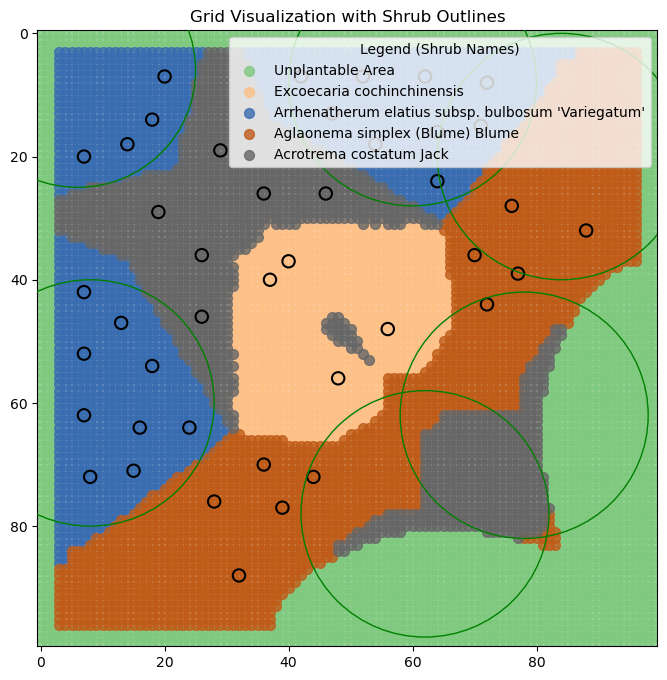

{'grid': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
test2 = plantHatchingAndAssignment(grid1, selected_plants, coordinates1, theme)

output_json = test2.hatch_allocate_plants(visualise=True)
print(output_json)